<a href="https://colab.research.google.com/github/subodh2708/deep-learning---tensorflow-2.0/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning in tensorflow part 3: Scaling up(Food vision Mini)

In [1]:
!nvidia-smi

Tue Aug 30 09:55:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-30 09:55:43--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-30 09:55:43 (89.5 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,compare_historys,walk_through_dir

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data('101_food_classes_10_percent.zip')

--2022-08-30 09:55:46--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 173.194.202.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   122MB/s    in 13s     

2022-08-30 09:55:59 (120 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

In [6]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pad_thai'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beef_carpaccio'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/panna_cotta'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hummus'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/gyoza'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_toast'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/edamame'.
There are 0 directories and 250 images in '101_fo

In [7]:
import tensorflow as tf
IMG_SIZE = (224,224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode = "categorical",
                                                                                image_size = IMG_SIZE)

test_data =tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                               label_mode= "categorical",
                                                               image_size = IMG_SIZE,
                                                               shuffle = "False")

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback =tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        monitor='val_accuracy',
                                                        save_weights_only= True,
                                                        save_best_only = True)

In [9]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2)
],name='data_augmentation')

In [10]:
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

input = layers.Input(shape=(224,224,3),name= "input_layers")
x = data_augmentation(input)
x= base_model(x,training= False)
x= layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation= 'softmax',name='output_layer')(x)
model = tf.keras.Model(input,outputs)

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layers (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [12]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history_all_classes_10_percent= model.fit(train_data_all_10_percent,
                                          epochs= 5,
                                          steps_per_epoch = len(train_data_all_10_percent),
                                          validation_data = test_data,
                                          validation_steps= int(0.15* len(test_data)),
                                          callbacks = [checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 49s 138ms/step - loss: 3.4819 - accuracy: 0.2457 - val_loss: 2.4557 - val_accuracy: 0.4401
Epoch 2/5
237/237 [==============================] - 27s 112ms/step - loss: 2.3545 - accuracy: 0.4607 - val_loss: 2.0336 - val_accuracy: 0.4944
Epoch 3/5
237/237 [==============================] - 26s 110ms/step - loss: 1.9996 - accuracy: 0.5246 - val_loss: 1.8642 - val_accuracy: 0.5244
Epoch 4/5
237/237 [==============================] - 25s 105ms/step - loss: 1.7938 - accuracy: 0.5624 - val_loss: 1.7771 - val_accuracy: 0.5376
Epoch 5/5
237/237 [==============================] - 23s 98ms/step - loss: 1.6416 - accuracy: 0.5933 - val_loss: 1.7449 - val_accuracy: 0.5421


In [13]:
feature_extraction_results = model.evaluate(test_data)


790/790 [==============================] - 39s 48ms/step - loss: 1.7114 - accuracy: 0.5552


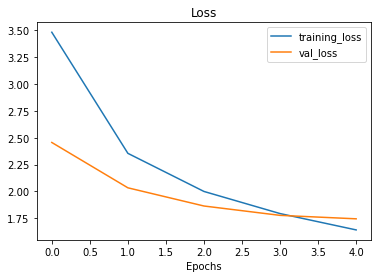

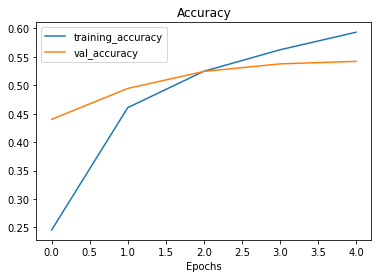

In [14]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-Tuning

In [15]:
base_model.trainable = True

for layer in base_model.layers[:-5]:
  layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
              metrics = ['accuracy'])

In [17]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layers True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
for layer_number,layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [19]:
fine_tune_epochs = 10

history_all_classes_10_percent_fine_tune =  model.fit(train_data_all_10_percent,
                                                      epochs = fine_tune_epochs,
                                                      validation_data = test_data,
                                                      validation_steps =int(0.15 * len(test_data)),
                                                      initial_epoch = history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 32s 105ms/step - loss: 1.4056 - accuracy: 0.6374 - val_loss: 1.6656 - val_accuracy: 0.5495
Epoch 6/10
237/237 [==============================] - 23s 95ms/step - loss: 1.2858 - accuracy: 0.6585 - val_loss: 1.6628 - val_accuracy: 0.5506
Epoch 7/10
237/237 [==============================] - 23s 96ms/step - loss: 1.1911 - accuracy: 0.6825 - val_loss: 1.6507 - val_accuracy: 0.5591
Epoch 8/10
237/237 [==============================] - 22s 93ms/step - loss: 1.1345 - accuracy: 0.6982 - val_loss: 1.6386 - val_accuracy: 0.5659
Epoch 9/10
237/237 [==============================] - 22s 91ms/step - loss: 1.0759 - accuracy: 0.7137 - val_loss: 1.6311 - val_accuracy: 0.5704
Epoch 10/10
237/237 [==============================] - 22s 90ms/step - loss: 1.0126 - accuracy: 0.7337 - val_loss: 1.6234 - val_accuracy: 0.5699


In [20]:
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)

790/790 [==============================] - 38s 48ms/step - loss: 1.5975 - accuracy: 0.5770


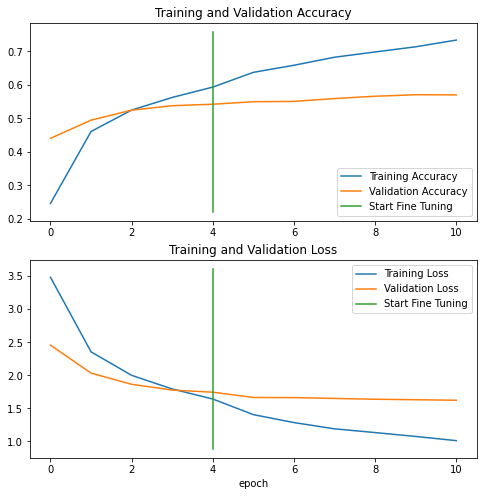

In [21]:
compare_historys(original_history = history_all_classes_10_percent,
                 new_history = history_all_classes_10_percent_fine_tune,
                 initial_epochs =5)

## saving and loading our model

In [22]:
model.save("/content/drive/MyDrive/Colab Notebooks/deep learning/101_food_classes_10_percent_saved_model")

In [23]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/deep learning/101_food_classes_10_percent_saved_model")

In [24]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 41s 51ms/step - loss: 1.5975 - accuracy: 0.5770


[1.5974797010421753, 0.5769504904747009]

In [25]:
results_all_classes_10_percent_fine_tune

[1.5974783897399902, 0.5769504904747009]

## Evaluate the performance

In [26]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2022-08-30 10:04:03--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.20.128, 108.177.98.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   105MB/s    in 0.4s    

2022-08-30 10:04:04 (105 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [27]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [28]:
import tensorflow as tf
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [29]:
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 42s 51ms/step - loss: 1.8027 - accuracy: 0.6078


[1.802722454071045, 0.6077623963356018]

## Making predictions with our trained model

In [30]:
preds_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 37s 45ms/step


In [31]:
preds_probs.shape

(25250, 101)